## Import and install necessary packages¶

In [158]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import calendar
import scipy

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
#pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Get merged and cleaned data

In [159]:
df = pd.read_csv('games_clean_df.csv')
df.head(10)

,Rank,Name,Genre,ESRB_Rating,Platform,Publisher,Developer,Global_Sales,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,metascore,userscore,date
0,20,Grand Theft Auto V,Action,M,PS3,Rockstar Games,Rockstar North,20.320,6.370,9.850,0.990,3.120,2013,97,8.300,"Sep 17, 2013"
1,21,Grand Theft Auto V,Action,M,PS4,Rockstar Games,Rockstar North,19.390,6.060,9.710,0.600,3.020,2014,97,8.300,"Nov 18, 2014"
2,31,Grand Theft Auto: Vice City,Action,M,PS2,Rockstar Games,Rockstar North,16.150,8.410,5.490,0.470,1.780,2002,95,8.800,"Oct 27, 2002"
3,33,Grand Theft Auto V,Action,M,X360,Rockstar Games,Rockstar North,15.860,9.060,5.330,0.060,1.420,2013,97,8.300,"Sep 17, 2013"
4,41,Call of Duty: Modern Warfare 3,Shooter,M,X360,Activision,Infinity Ward,14.820,9.070,4.290,0.130,1.330,2011,88,3.400,"Nov 08, 2011"
5,42,Call of Duty: Black Ops,Shooter,M,X360,Activision,Treyarch,14.740,9.760,3.730,0.110,1.140,2010,87,6.400,"Nov 09, 2010"
6,46,Red Dead Redemption 2,Action-Adventure,M,PS4,Rockstar Games,Rockstar Games,13.940,5.260,6.210,0.210,2.260,2018,97,7.700,"Oct 26, 2018"
7,47,Call of Duty: Black Ops II,Shooter,M,X360,Activision,Treyarch,13.860,8.270,4.320,0.070,1.200,2012,83,5.000,"Nov 13, 2012"
8,48,Call of Duty: Black Ops II,Shooter,M,PS3,Activision,Treyarch,13.800,4.990,5.880,0.650,2.280,2012,83,5.400,"Nov 13, 2012"
9,50,Call of Duty: Modern Warfare 2,Shooter,M,X360,Activision,Infinity Ward,13.530,8.540,3.630,0.080,1.280,2009,94,6.400,"Nov 10, 2009"


In [160]:
# new column for years ago
df['years_ago'] = 2020 - df['date'].str[-4:].astype(int)
# take first 3 characters of date for month abbreviation
df['month_abbrev'] = df['date'].str[:3]
def month_numerize(abbrev):
    for k, v in enumerate(calendar.month_abbr):
        if abbrev == v:
            return k
        
# column for numerical representations of month (Jan is 01, Feb is 02, etc.)
df['month_num'] = df['month_abbrev'].apply(month_numerize)
# months ago from April 2020
df['months_ago'] = (df['years_ago'] * 12) + (12 - df['month_num']) + 4 - 12
# dummy categories for months, haven't put this into the dataframe yet
month_dummies = pd.get_dummies(df['month_abbrev'], drop_first=True)

In [161]:
df

,Rank,Name,Genre,ESRB_Rating,Platform,Publisher,Developer,Global_Sales,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,metascore,userscore,date,years_ago,month_abbrev,month_num,months_ago
0,20,Grand Theft Auto V,Action,M,PS3,Rockstar Games,Rockstar North,20.320,6.370,9.850,0.990,3.120,2013,97,8.300,"Sep 17, 2013",7,Sep,9,79
1,21,Grand Theft Auto V,Action,M,PS4,Rockstar Games,Rockstar North,19.390,6.060,9.710,0.600,3.020,2014,97,8.300,"Nov 18, 2014",6,Nov,11,65
2,31,Grand Theft Auto: Vice City,Action,M,PS2,Rockstar Games,Rockstar North,16.150,8.410,5.490,0.470,1.780,2002,95,8.800,"Oct 27, 2002",18,Oct,10,210
3,33,Grand Theft Auto V,Action,M,X360,Rockstar Games,Rockstar North,15.860,9.060,5.330,0.060,1.420,2013,97,8.300,"Sep 17, 2013",7,Sep,9,79
4,41,Call of Duty: Modern Warfare 3,Shooter,M,X360,Activision,Infinity Ward,14.820,9.070,4.290,0.130,1.330,2011,88,3.400,"Nov 08, 2011",9,Nov,11,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6237,19777,Europa Universalis III,Strategy,E,PC,Paradox Interactive,Paradox Interactive,0.010,nan,0.010,nan,0.000,2007,83,8.400,"Jan 23, 2007",13,Jan,1,159
6238,19789,Monopoly Tycoon,Simulation,E,PC,Atari,Deep Red Games,0.010,nan,0.010,nan,0.000,2001,85,7.700,"Sep 24, 2001",19,Sep,9,223
6239,19793,Call of Duty,Shooter,T,PC,Activision,Infinity Ward,0.010,nan,0.010,nan,0.000,2003,91,8.500,"Oct 29, 2003",17,Oct,10,198
6240,19813,Dawn of Discovery: Venice,Simulation,T,PC,Ubisoft,Blue Byte Software / Related Designs,0.010,nan,0.000,nan,0.000,2010,78,7.900,"Feb 26, 2010",10,Feb,2,122


In [185]:
consoles = {
    'N64': {'Family': 'Nintendo', 'Release': 285, 'Successor': 'GC'},
    'GC': {'Family': 'Nintendo', 'Release': 222, 'Successor': 'WII'},
    'WII': {'Family': 'Nintendo', 'Release': 160, 'Successor': 'WIIU'},
    'WIIU': {'Family': 'Nintendo', 'Release': 88, 'Successor': 'Switch'},
    'Switch': {'Family': 'Nintendo', 'Release': 36, 'Successor': 'current'},
    'PS': {'Family': 'Sony', 'Release': 303, 'Successor': 'PS2'},
    'PS2': {'Family': 'Sony', 'Release': 240, 'Successor': 'PS3'},
    'PS3': {'Family': 'Sony', 'Release': 160, 'Successor': 'PS4'},
    'PS4': {'Family': 'Sony', 'Release': 77, 'Successor': 'current'},
    'XBOX': {'Family': 'Microsoft', 'Release': 220, 'Successor': 'X360'},
    'X360': {'Family': 'Microsoft', 'Release': 172, 'Successor': 'XONE'},
    'XONE': {'Family': 'Microsoft', 'Release': 77, 'Successor': 'current'},
    'GBA': {'Family': 'Nintendo', 'Release': 228, 'Successor': 'NDS'},
    'DS': {'Family': 'Nintendo', 'Release': 184, 'Successor': 'Three_DS'},
    '3DS': {'Family': 'Nintendo', 'Release': 109, 'Successor': 'current'},
    'PSP': {'Family': 'Sony', 'Release': 183, 'Successor': 'VITA'},
    'VITA': {'Family': 'Sony', 'Release': 99, 'Successor': 'current'},
    'DC': {'Family': 'Sega', 'Release': 256, 'Successor': 'current'},
    'PC': {'Family': 'PC', 'Release': 0, 'Successor': 'current'},
}

In [182]:
consoles['N64']['Family']

'Nintendo'

## EDA

### General

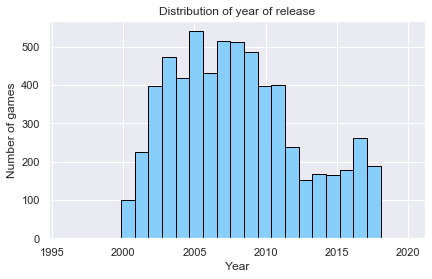

In [163]:
num_years = df["Year"].max() - df["Year"].min() + 1
plt.hist(df["Year"], bins=num_years, color="lightskyblue", edgecolor="black")
plt.title("Distribution of year of release")
plt.xlabel("Year")
plt.ylabel("Number of games");

In [164]:
df.columns

Index(['Rank', 'Name', 'Genre', 'ESRB_Rating', 'Platform', 'Publisher',
       'Developer', 'Global_Sales', 'NA_Sales', 'PAL_Sales', 'JP_Sales',
       'Other_Sales', 'Year', 'metascore', 'userscore', 'date', 'years_ago',
       'month_abbrev', 'month_num', 'months_ago'],
      dtype='object')

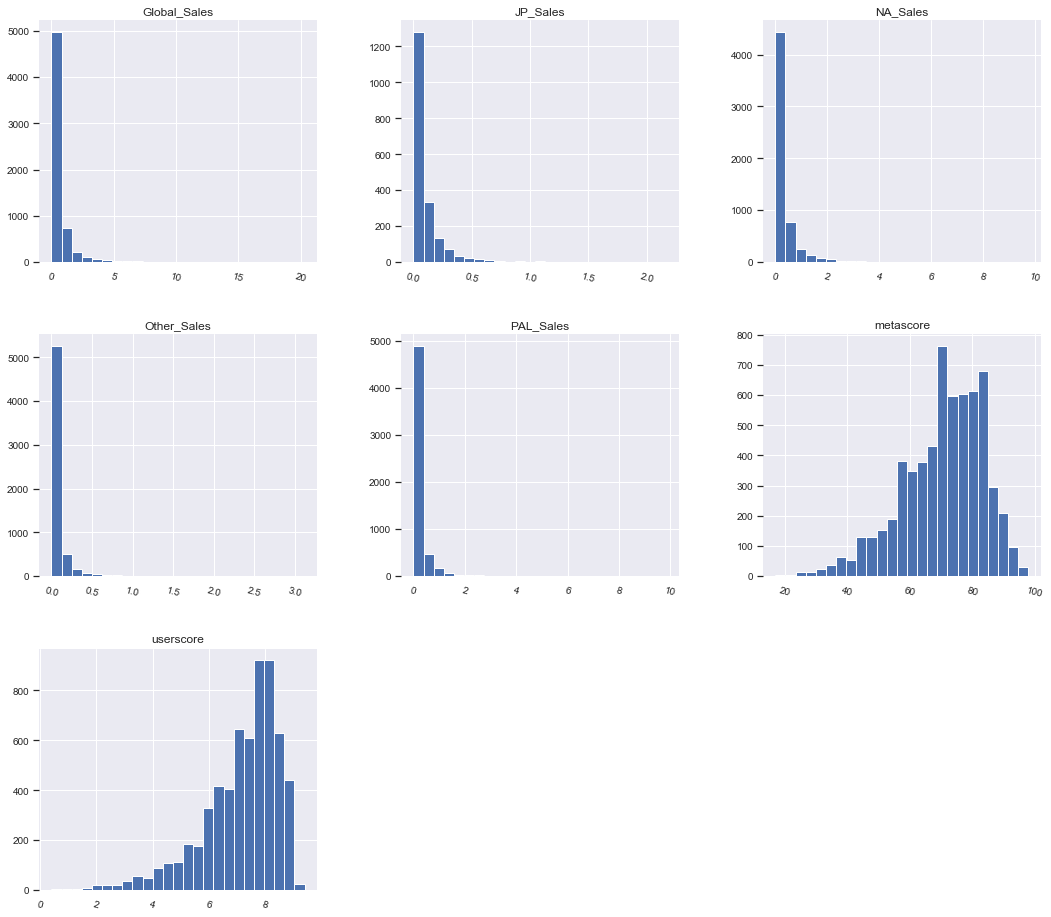

In [165]:
df1=df[['Genre', 'ESRB_Rating', 'Platform', 'Publisher',
    'Developer', 'Global_Sales', 'NA_Sales', 'PAL_Sales', 'JP_Sales', 'Other_Sales',
    'metascore', 'userscore']]
h = df1.hist(bins=25,figsize=(16,16),xlabelsize='10',ylabelsize='10',xrot=-15)
sns.despine(left=True, bottom=True)
[x.title.set_size(12) for x in h.ravel()];
[x.yaxis.tick_left() for x in h.ravel()];

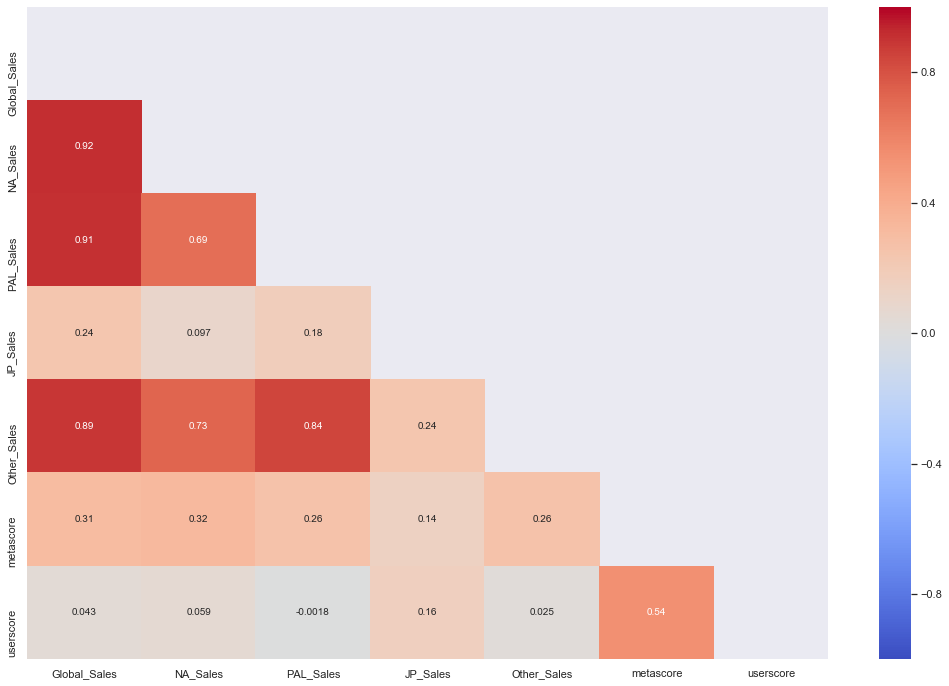

In [166]:
df2 = df[['Genre', 'ESRB_Rating', 'Platform', 'Publisher',
    'Developer', 'Global_Sales', 'NA_Sales', 'PAL_Sales', 'JP_Sales', 'Other_Sales',
    'metascore', 'userscore']]
f, ax = plt.subplots(figsize=(16, 12))
matrix = np.triu(df2.corr())
sns.heatmap(df2.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask = matrix)

### Video Game Genres

In [167]:
genre_df = df.groupby('Genre', as_index=False).agg({'Global_Sales': ['sum','count']})
genre_df.columns = genre_df.columns.droplevel(0)
genre_df.reset_index()

,index,,sum,count
0,0,Action,770.870,1157
1,1,Action-Adventure,114.040,113
2,2,Adventure,153.630,370
3,3,Board Game,0.300,1
4,4,Education,0.090,1
5,5,Fighting,182.540,335
6,6,MMO,7.900,16
7,7,Misc,211.590,305
8,8,Music,24.580,34
9,9,Party,2.450,9


In [168]:
genre_df.columns = ['Genre', 'Sum', 'Count']
genre_df = genre_df.sort_values("Count", ascending=False)

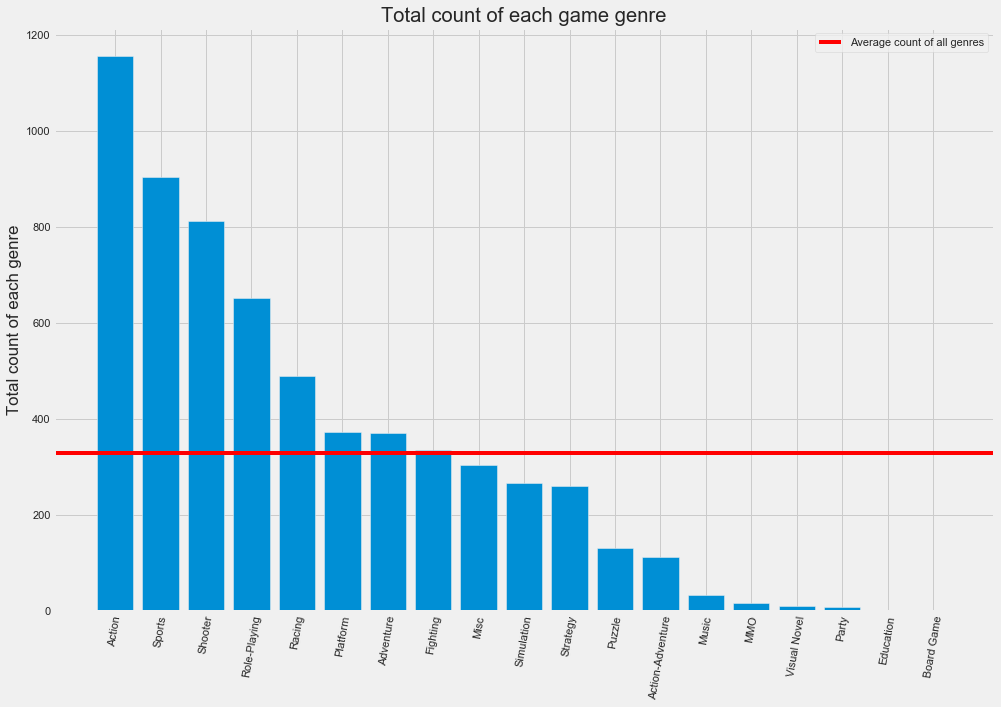

In [169]:
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(figsize=(15,10))

ax.bar(genre_df["Genre"],genre_df["Count"])
ax.axhline(genre_df["Count"].mean(), color="red", label="Average count of all genres")

ax.set_xticklabels(genre_df["Genre"], rotation=80)

ax.set_ylabel("Total count of each genre")
ax.set_title('Total count of each game genre')
ax.legend()

plt.show()

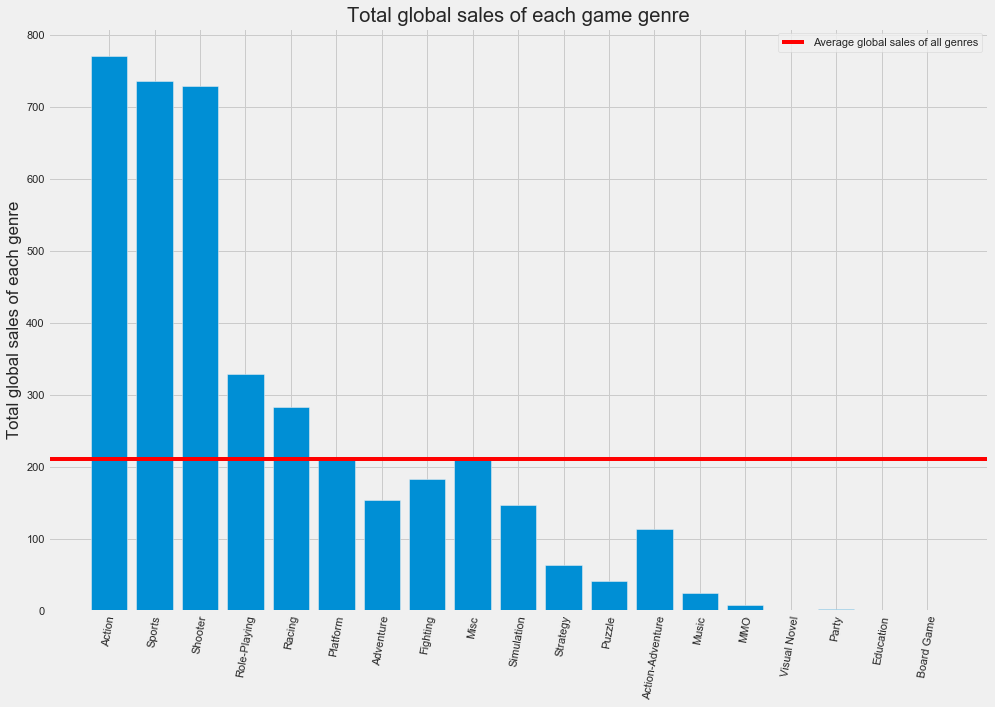

In [170]:
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(figsize=(15,10))

ax.bar(genre_df["Genre"],genre_df["Sum"])
ax.axhline(genre_df["Sum"].mean(), color="red", label="Average global sales of all genres")

ax.set_xticklabels(genre_df["Genre"], rotation=80)

ax.set_ylabel("Total global sales of each genre")
ax.set_title('Total global sales of each game genre')
ax.legend()

plt.show()

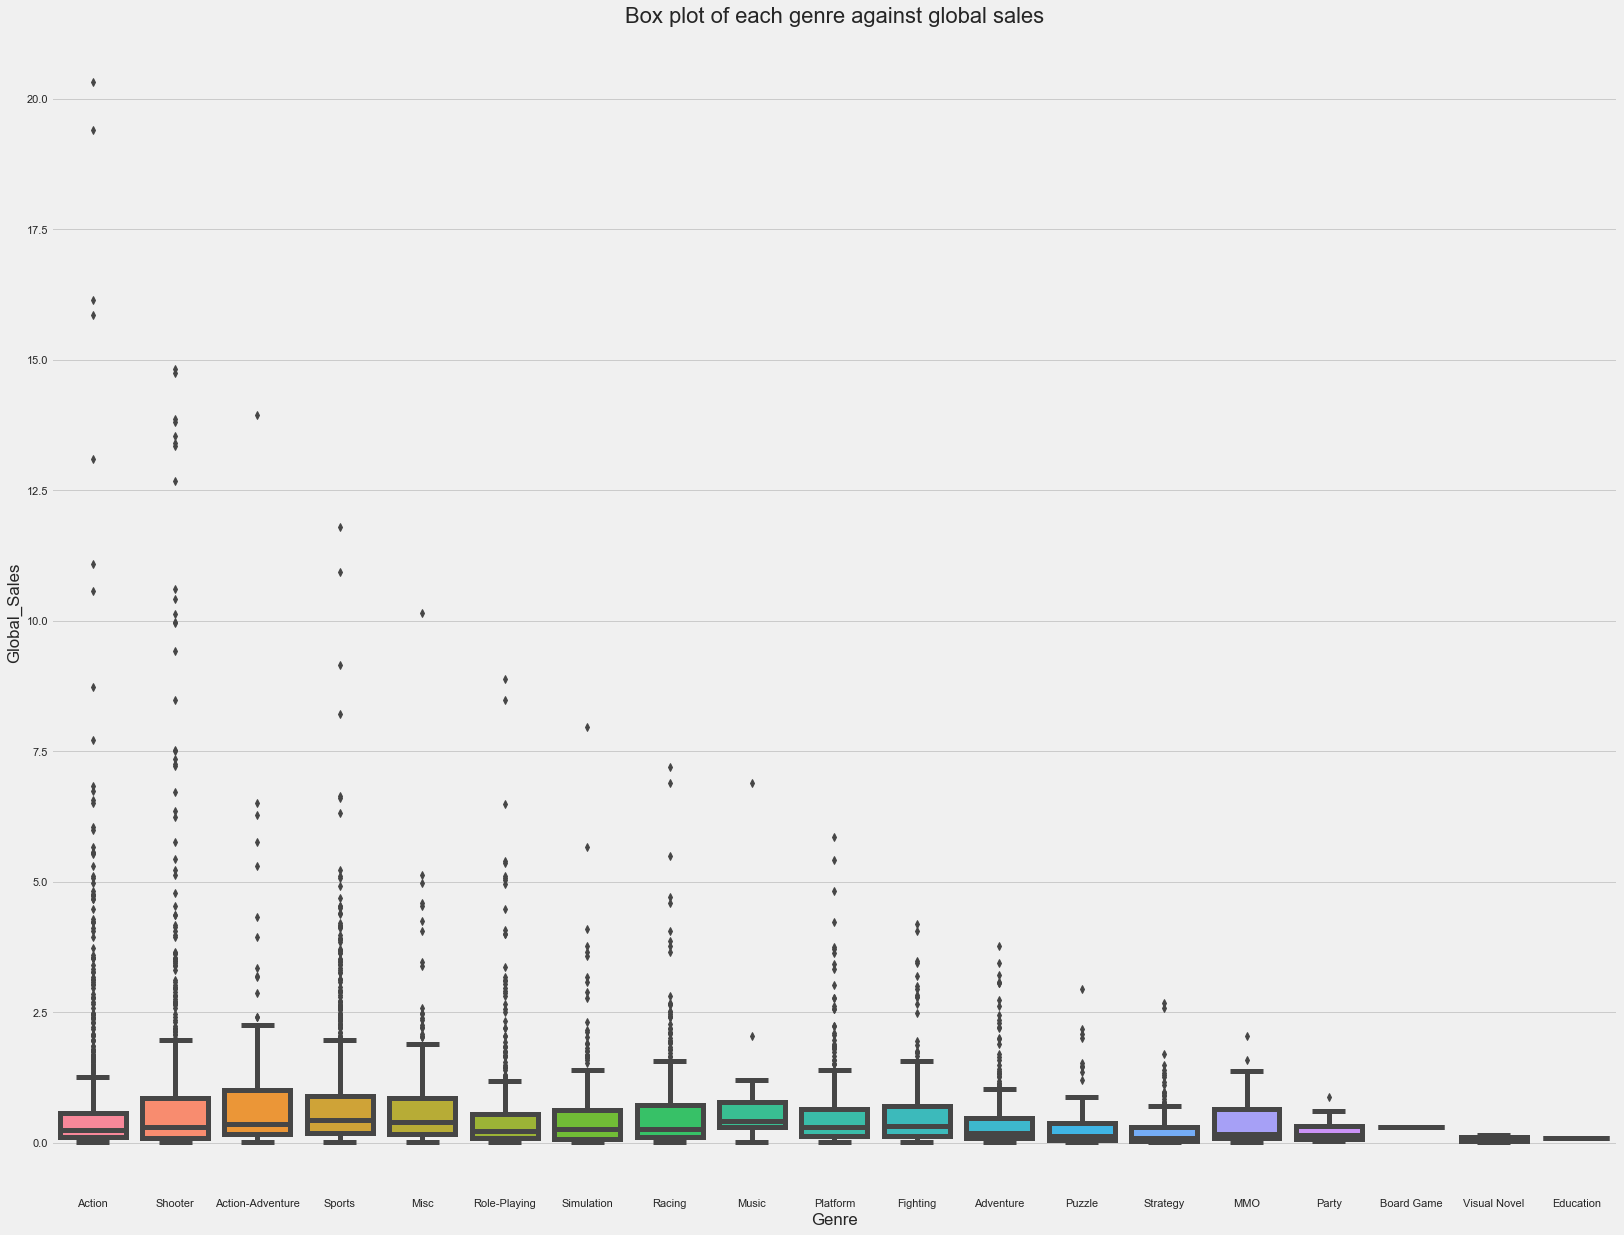

In [171]:
fig, ax = plt.subplots(figsize=(25,20))
ax = sns.boxplot(x=df['Genre'], y=df['Global_Sales'],linewidth=5, saturation=5)
ax.set_title('Box plot of each genre against global sales', fontsize= 22)
ax

### Video Game Platforms

In [172]:
platform_df = df.groupby('Platform', as_index=False).agg({'Global_Sales': ['sum','count']})
platform_df.columns = platform_df.columns.droplevel(0)
platform_df.reset_index()

,index,,sum,count
0,0,3DS,51.460,146
1,1,DC,3.020,12
2,2,DS,155.130,388
3,3,GBA,93.550,215
4,4,GC,88.370,312
5,5,N64,8.980,17
6,6,PC,118.710,490
7,7,PS,59.940,78
8,8,PS2,768.320,1041
9,9,PS3,694.170,653


In [173]:
platform_df.columns = ['Platform', 'Sum', 'Count']
platform_df = platform_df.sort_values("Count", ascending=False)
platform_df

,Platform,Sum,Count
8,PS2,768.320,1041
16,X360,723.860,753
9,PS3,694.170,653
17,XBOX,176.610,540
6,PC,118.710,490
10,PS4,402.410,400
14,WII,251.690,394
2,DS,155.130,388
11,PSP,154.980,343
4,GC,88.370,312


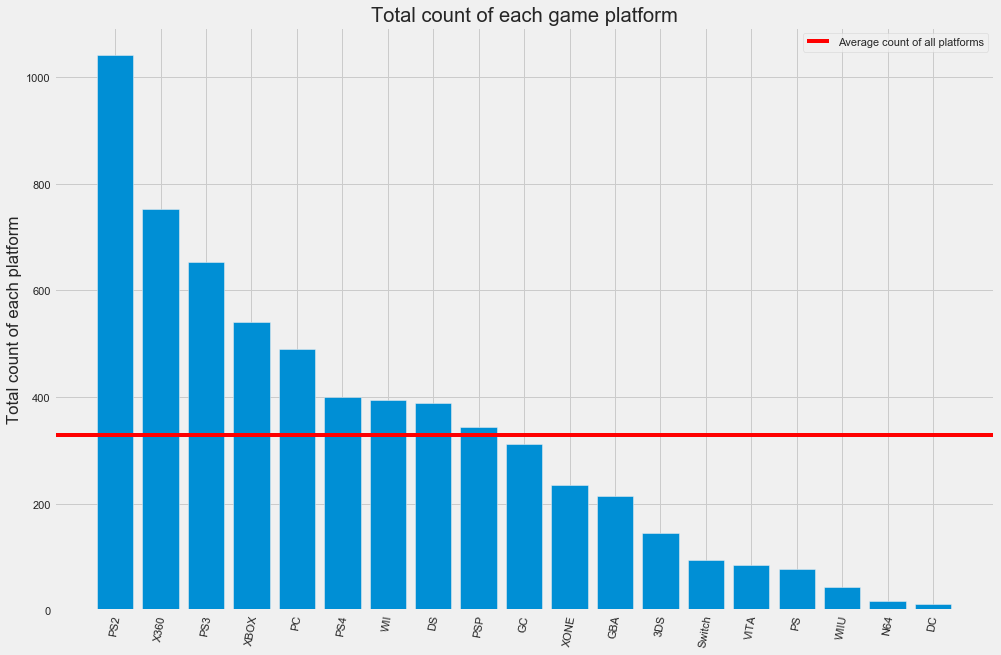

In [174]:
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(figsize=(15,10))

ax.bar(platform_df["Platform"],platform_df["Count"])
ax.axhline(platform_df["Count"].mean(), color="red", label="Average count of all platforms")

ax.set_xticklabels(platform_df["Platform"], rotation=80)

ax.set_ylabel("Total count of each platform")
ax.set_title('Total count of each game platform')
ax.legend()

plt.show()

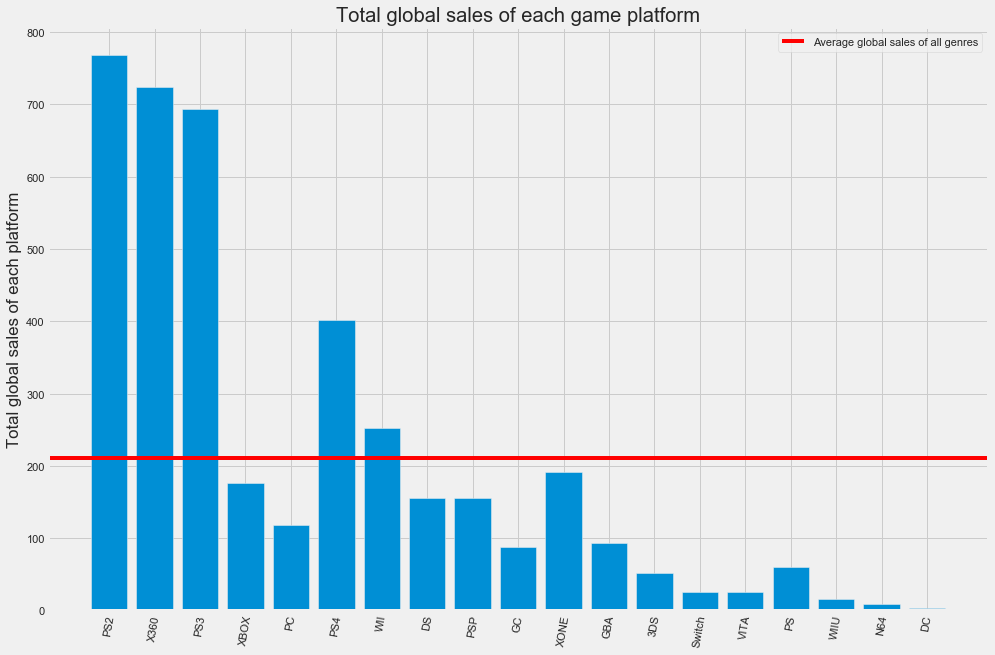

In [175]:
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(figsize=(15,10))

ax.bar(platform_df["Platform"],platform_df["Sum"])
ax.axhline(platform_df["Sum"].mean(), color="red", label="Average global sales of all genres")

ax.set_xticklabels(platform_df["Platform"], rotation=80)

ax.set_ylabel("Total global sales of each platform")
ax.set_title('Total global sales of each game platform')
ax.legend()

plt.show()

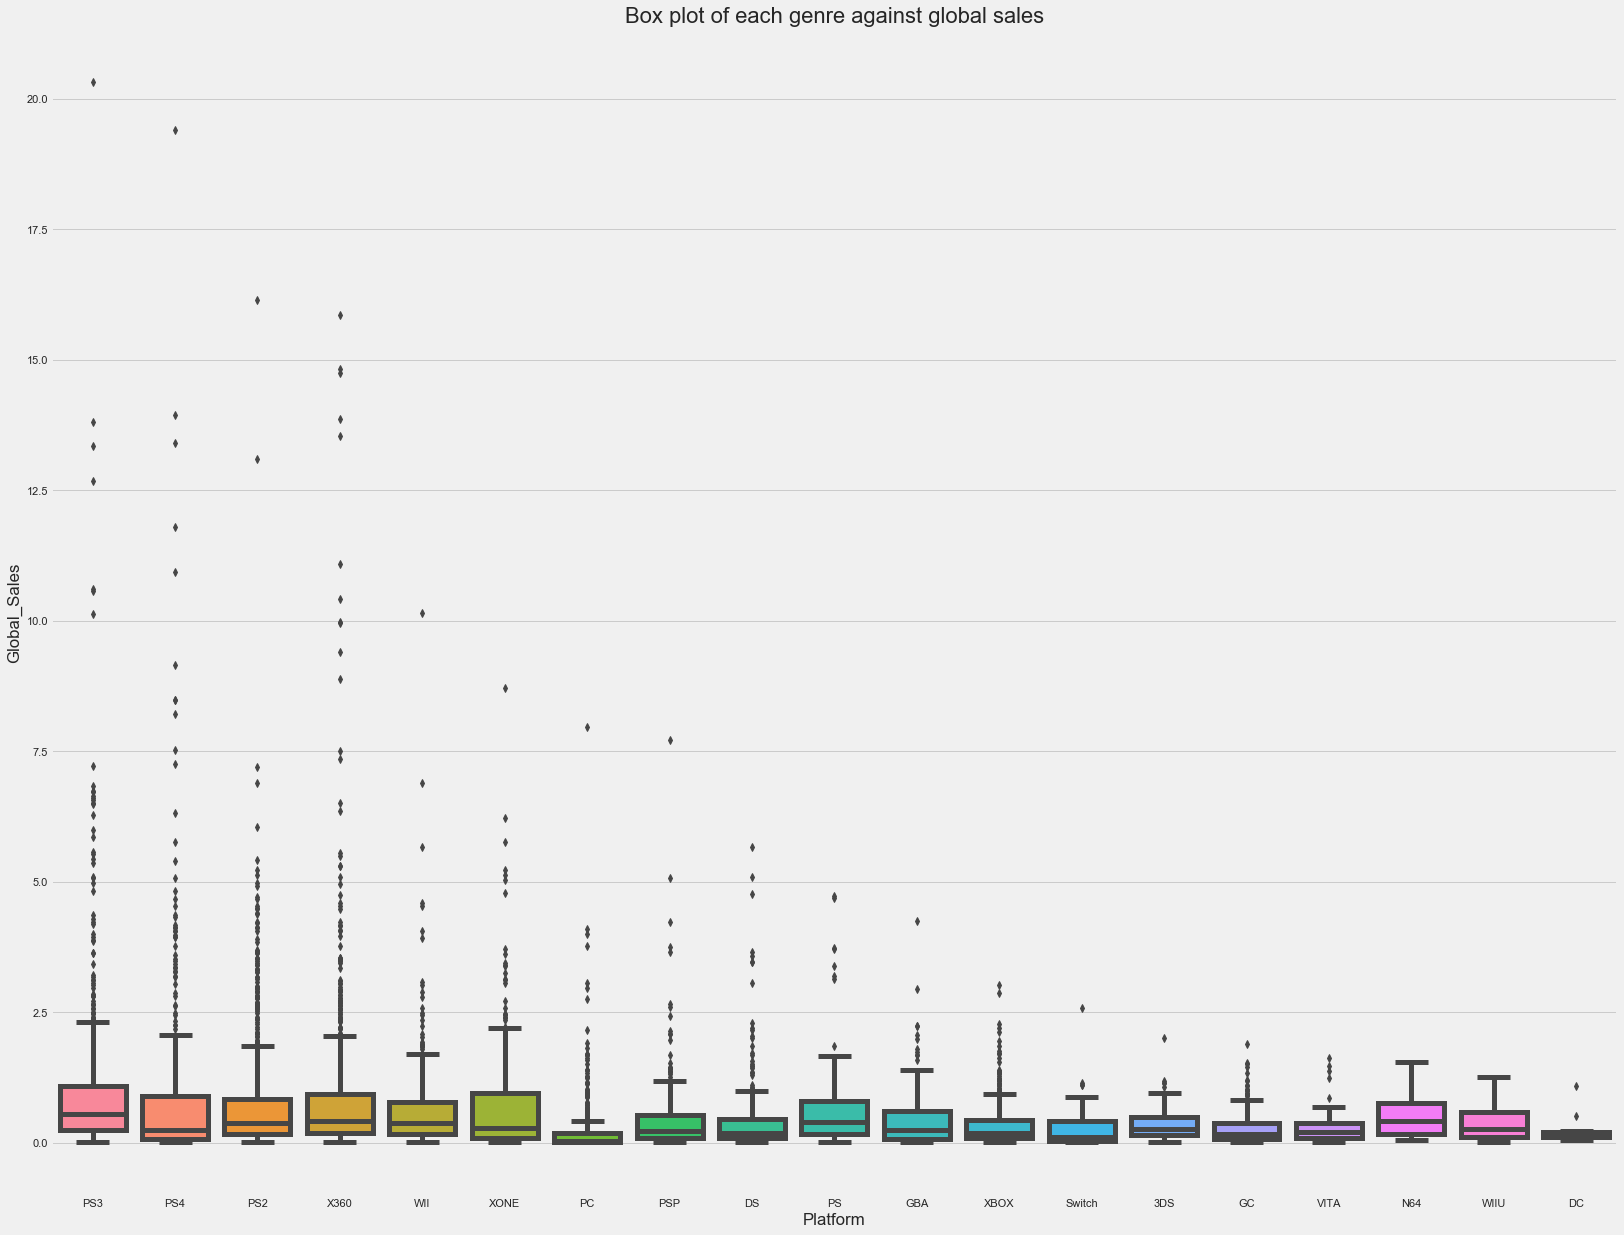

In [176]:
fig, ax = plt.subplots(figsize=(25,20))
ax = sns.boxplot(x=df['Platform'], y=df['Global_Sales'],linewidth=5, saturation=5)
ax.set_title('Box plot of each genre against global sales', fontsize= 22)
ax

### Video Game Platform Companies

In [186]:
for index, row in df.iterrows():
    company = consoles[row['Platform']]['Family']
    df.at[index, 'Family'] = company

In [187]:
df

,Rank,Name,Genre,ESRB_Rating,Platform,Publisher,Developer,Global_Sales,NA_Sales,PAL_Sales,...,Other_Sales,Year,metascore,userscore,date,years_ago,month_abbrev,month_num,months_ago,Family
0,20,Grand Theft Auto V,Action,M,PS3,Rockstar Games,Rockstar North,20.320,6.370,9.850,...,3.120,2013,97,8.300,"Sep 17, 2013",7,Sep,9,79,Sony
1,21,Grand Theft Auto V,Action,M,PS4,Rockstar Games,Rockstar North,19.390,6.060,9.710,...,3.020,2014,97,8.300,"Nov 18, 2014",6,Nov,11,65,Sony
2,31,Grand Theft Auto: Vice City,Action,M,PS2,Rockstar Games,Rockstar North,16.150,8.410,5.490,...,1.780,2002,95,8.800,"Oct 27, 2002",18,Oct,10,210,Sony
3,33,Grand Theft Auto V,Action,M,X360,Rockstar Games,Rockstar North,15.860,9.060,5.330,...,1.420,2013,97,8.300,"Sep 17, 2013",7,Sep,9,79,Microsoft
4,41,Call of Duty: Modern Warfare 3,Shooter,M,X360,Activision,Infinity Ward,14.820,9.070,4.290,...,1.330,2011,88,3.400,"Nov 08, 2011",9,Nov,11,101,Microsoft
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6237,19777,Europa Universalis III,Strategy,E,PC,Paradox Interactive,Paradox Interactive,0.010,nan,0.010,...,0.000,2007,83,8.400,"Jan 23, 2007",13,Jan,1,159,PC
6238,19789,Monopoly Tycoon,Simulation,E,PC,Atari,Deep Red Games,0.010,nan,0.010,...,0.000,2001,85,7.700,"Sep 24, 2001",19,Sep,9,223,PC
6239,19793,Call of Duty,Shooter,T,PC,Activision,Infinity Ward,0.010,nan,0.010,...,0.000,2003,91,8.500,"Oct 29, 2003",17,Oct,10,198,PC
6240,19813,Dawn of Discovery: Venice,Simulation,T,PC,Ubisoft,Blue Byte Software / Related Designs,0.010,nan,0.000,...,0.000,2010,78,7.900,"Feb 26, 2010",10,Feb,2,122,PC


In [188]:
company_df = df.groupby('Family', as_index=False).agg({'Global_Sales': ['sum','count']})
company_df.columns = company_df.columns.droplevel(0)
company_df.reset_index()

,index,,sum,count
0,0,Microsoft,1092.540,1529
1,1,Nintendo,689.740,1611
2,2,PC,118.710,490
3,3,Sega,3.020,12
4,4,Sony,2104.860,2600


In [189]:
company_df.columns = ['Family', 'Sum', 'Count']
company_df = company_df.sort_values("Count", ascending=False)
company_df

,Family,Sum,Count
4,Sony,2104.860,2600
1,Nintendo,689.740,1611
0,Microsoft,1092.540,1529
2,PC,118.710,490
3,Sega,3.020,12


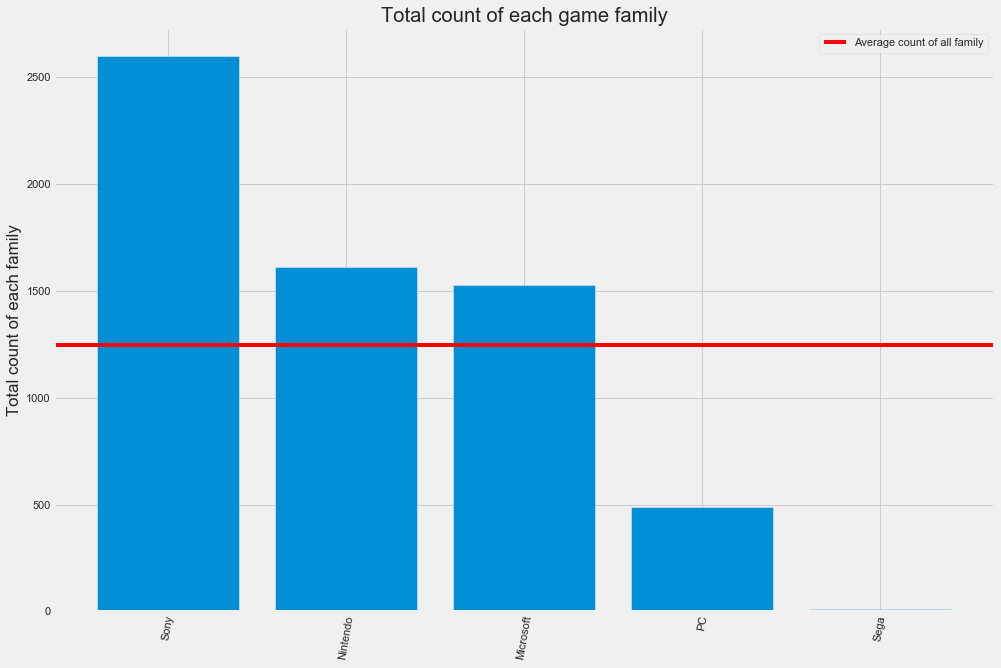

In [191]:
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(figsize=(15,10))

ax.bar(company_df["Family"],company_df["Count"])
ax.axhline(company_df["Count"].mean(), color="red", label="Average count of all family")

ax.set_xticklabels(company_df["Family"], rotation=80)

ax.set_ylabel("Total count of each family")
ax.set_title('Total count of each game family')
ax.legend()

plt.show()

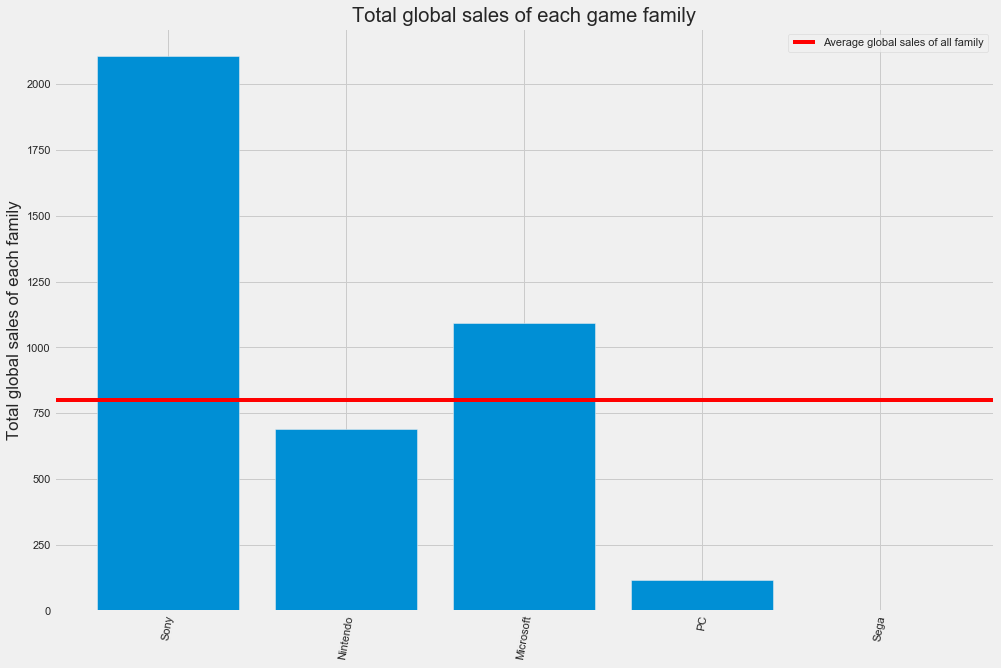

In [192]:
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(figsize=(15,10))

ax.bar(company_df["Family"],company_df["Sum"])
ax.axhline(company_df["Sum"].mean(), color="red", label="Average global sales of all family")

ax.set_xticklabels(company_df["Family"], rotation=80)

ax.set_ylabel("Total global sales of each family")
ax.set_title('Total global sales of each game family')
ax.legend()

plt.show()

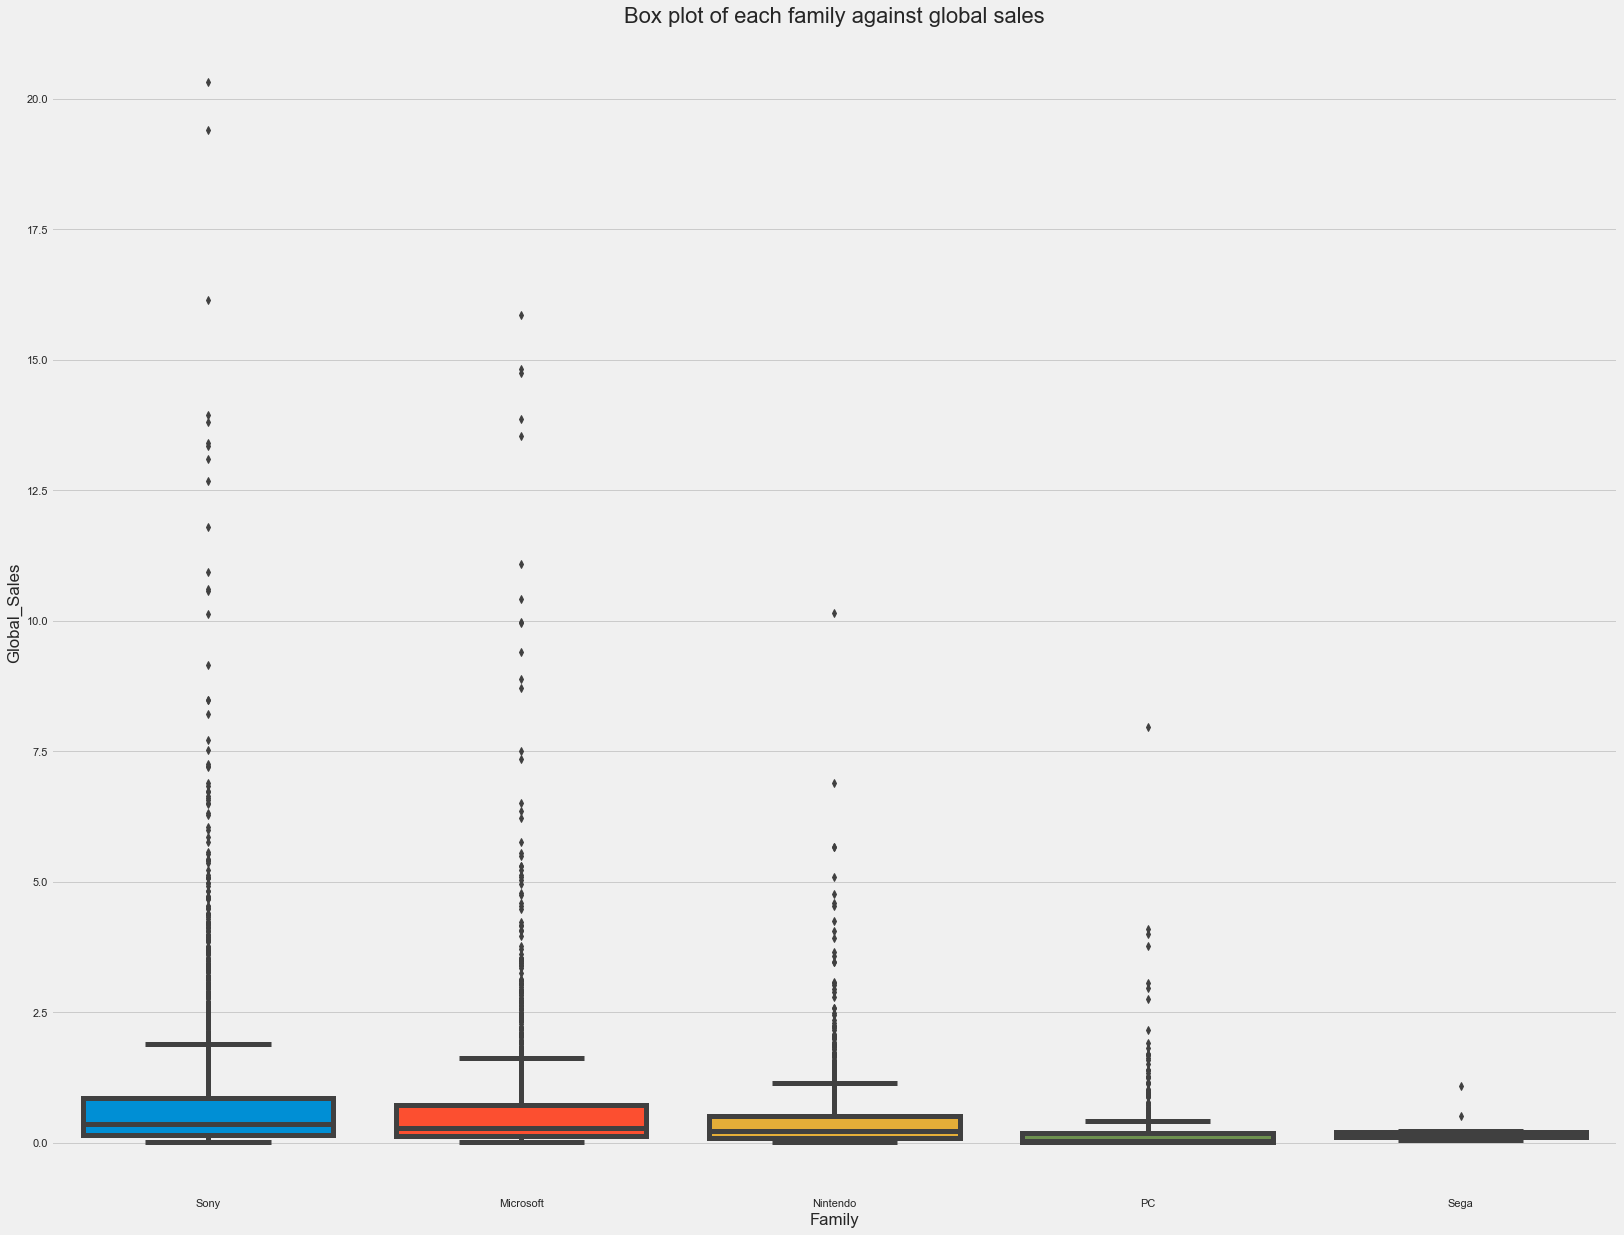

In [193]:
fig, ax = plt.subplots(figsize=(25,20))
ax = sns.boxplot(x=df['Family'], y=df['Global_Sales'],linewidth=5, saturation=5)
ax.set_title('Box plot of each family against global sales', fontsize= 22)
ax

### ESB Ratings

In [ ]:
rating_df = df.groupby('ESRB_Rating', as_index=False).agg({'Global_Sales': ['sum','count']})
rating_df.columns = rating_df.columns.droplevel(0)
rating_df.reset_index()
rating_df

In [ ]:
rating_df.columns = ['Rating', 'Sum', 'Count']
rating_df = rating_df.sort_values("Count", ascending=False)
rating_df

In [ ]:
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(figsize=(15,10))

ax.bar(rating_df["Rating"],rating_df["Count"])
ax.axhline(rating_df["Count"].mean(), color="red", label="Average count of all ESRB rating")

ax.set_xticklabels(rating_df["Rating"], rotation=0)

ax.set_ylabel("Total count of each ESRB rating")
ax.set_title('Total count of each ESRB rating')
ax.legend()

plt.show()

In [ ]:
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(figsize=(15,10))

ax.bar(rating_df["Rating"],rating_df["Sum"])
ax.axhline(rating_df["Sum"].mean(), color="red", label="Average global sales of all ESRB ratigs")

ax.set_xticklabels(rating_df["Rating"], rotation=80)

ax.set_ylabel("Total global sales of each ESRB rating")
ax.set_title('Total global sales of each ESRB rating')
ax.legend()

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(25,20))
ax = sns.boxplot(x=df['ESRB_Rating'], y=df['Global_Sales'],linewidth=5, saturation=5)
ax.set_title('Box plot of each ESRB rating against global sales', fontsize= 22)
ax

## Hypothesis Testing (alpha = 0.05)

### Null Hypothesis: Equal distribution of global sales across all genres
### Alternate Hypothesis: Not equal distribution of global sales across all genres

In [211]:
expected = genre_df['Sum'].sum() / genre_df.shape[0]
expected_array = np.full((19,), expected)

In [213]:
scipy.stats.chisquare(genre_df['Sum'], f_exp=expected_array)

Power_divergenceResult(statistic=5663.000910231552, pvalue=0.0)

Because the pvalue is less than alpha, we reject the hypothesis that there is equal distribution of global sales across all video game genres.

### Null Hypothesis: Equal distribution of global sales across all platforms
### Alternate Hypothesis: Not equal distribution of global sales across all platforms

In [180]:
expected = platform_df['Sum'].sum() / platform_df.shape[0]
expected_array = np.full((platform_df.shape[0],), expected)

In [181]:
scipy.stats.chisquare(platform_df['Sum'], f_exp=expected_array)

Power_divergenceResult(statistic=5356.762379822746, pvalue=0.0)

Because the pvalue is less than alpha, we reject the hypothesis that there is equal distribution of global sales across all video game platforms.

### Null Hypothesis: Equal distribution of global sales across all video game family
### Alternate Hypothesis: Not equal distribution of global sales across all video game family

In [194]:
expected = company_df['Sum'].sum() / company_df.shape[0]
expected_array = np.full((company_df.shape[0],), expected)

In [195]:
scipy.stats.chisquare(company_df['Sum'], f_exp=expected_array)

Power_divergenceResult(statistic=3616.6226242308617, pvalue=0.0)

Because the pvalue is less than alpha, we reject the hypothesis that there is equal distribution of global sales across all video game platforms.

### Null Hypothesis: Equal distribution of global sales across all video game ESRB ratings
### Alternate Hypothesis: Not equal distribution of global sales across all video game ESRB ratings

In [197]:
expected = rating_df['Sum'].sum() / rating_df.shape[0]
expected_array = np.full((rating_df.shape[0],), expected)

In [198]:
scipy.stats.chisquare(rating_df['Sum'], f_exp=expected_array)

Power_divergenceResult(statistic=1602.069653194023, pvalue=0.0)